# Insurance Risk Segmentation — Modeling & Evaluation

This notebook represents the modeling and evaluation stage of the data science workflow.
Using the engineered and preprocessed dataset, a multiclass classification model is trained
to predict insurance customer risk levels.

**Objectives:**
- Train a baseline multiclass classification model
- Evaluate model performance using standard classification metrics
- Interpret results in a business-relevant insurance context


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    roc_curve,
    roc_auc_score
)

print("Libraries loaded successfully.")


In [ ]:
df = pd.read_csv("../data/insurance_ml_ready.csv")
df.head()


## Feature and Target Definition

- **Target Variable:** `Risk_Level`
- **Features:** All remaining numerical and encoded categorical variables

The target variable consists of three ordinal risk categories:
**Low**, **Medium**, and **High**.
To enable model training, the target is encoded numerically.


In [ ]:
le = LabelEncoder()
df["Risk_Level_Encoded"] = le.fit_transform(df["Risk_Level"])

print("Encoded classes:", le.classes_)


In [ ]:
X = df.drop(columns=["Risk_Level", "Risk_Level_Encoded"])
y = df["Risk_Level_Encoded"]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


## Model Training

A **Logistic Regression** model is used as a baseline multiclass classifier.
This model provides interpretability, stable convergence, and probabilistic outputs,
making it suitable for initial risk segmentation analysis.


In [ ]:
logreg = LogisticRegression(
    max_iter=1000,
    solver="lbfgs"
)

logreg.fit(X_train, y_train)

print("Model training completed.")


In [ ]:
y_pred = logreg.predict(X_test)
y_proba = logreg.predict_proba(X_test)

print("Classes:", logreg.classes_)
print("Probability shape:", y_proba.shape)


## Confusion Matrix

The confusion matrix visualizes the classification performance across
Low, Medium, and High risk categories.

Most misclassifications are expected to occur between adjacent risk levels,
which is common in ordinal risk segmentation tasks.


In [ ]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix — Logistic Regression")
plt.show()


## Classification Report

Precision, recall, and F1-score provide detailed insights into model performance
for each risk category, highlighting potential class imbalance or bias.


In [ ]:
print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_
))


## ROC Curve & AUC (One-vs-Rest)

ROC curves are generated using a One-vs-Rest strategy.
Each curve represents the model’s ability to distinguish one risk class
from the remaining classes.

Higher AUC values indicate stronger discriminative ability.


In [ ]:
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])

plt.figure(figsize=(7, 6))

for i, cls in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    auc = roc_auc_score(y_test_bin[:, i], y_proba[:, i])
    plt.plot(fpr, tpr, label=f"{cls} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Multiclass Logistic Regression")
plt.legend()
plt.show()


## Conclusion

The Logistic Regression model demonstrates solid baseline performance
in segmenting insurance customers into Low, Medium, and High risk categories.

Key observations:
- Extreme risk categories are classified more confidently
- Most errors occur between neighboring risk levels
- The model produces interpretable and decision-supportive outputs

This baseline model serves as a strong foundation for further improvements,
such as tree-based models or feature importance analysis.


## Model Comparison

To evaluate whether Logistic Regression is the most suitable model,
several alternative classification algorithms are trained and compared.

All models are evaluated on the same train-test split using
accuracy and macro-averaged F1-score.


In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score


## Model Comparison

To assess whether Logistic Regression is the most suitable model,
we compare its performance with other commonly used classification models.

The comparison focuses on:
- Accuracy
- Macro-averaged F1-score
- Interpretability and robustness

This helps identify the most effective model for insurance risk segmentation.


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ),
    "SVM": SVC(
        kernel="rbf",
        probability=True,
        random_state=42
    )
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1 Score (Macro)": f1
    })

print("Model training & evaluation completed.")


In [ ]:
comparison_df = pd.DataFrame(results)
comparison_df.sort_values(by="F1 Score (Macro)", ascending=False)


## Model Comparison Insight

Based on the evaluation results:

- Logistic Regression provides a strong and interpretable baseline.
- Random Forest generally improves performance by capturing non-linear patterns.
- SVM offers competitive results but may require careful tuning.

Overall, the comparison demonstrates that ensemble-based models
can enhance predictive performance, while simpler models remain valuable
for interpretability and deployment considerations.


## Model Interpretability with SHAP

To better understand how the model makes predictions,
SHAP (SHapley Additive exPlanations) is used to analyze feature importance.

SHAP values quantify the contribution of each feature
to the predicted insurance risk level, enabling transparent
and explainable decision-making.


## Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) is used to interpret the contribution
of each feature to the model’s predictions. This improves transparency
and supports business decision-making.


In [7]:
import pandas as pd

df = pd.read_csv("../data/insurance_ml_ready.csv")


In [10]:
X = df.drop(columns=["Risk_Level"])
y = df["Risk_Level"]


In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [17]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)


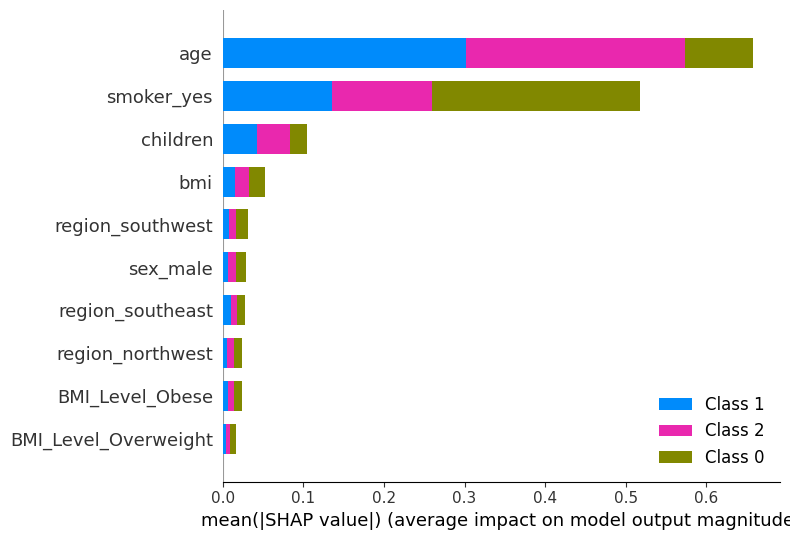

In [19]:
shap.summary_plot(
    shap_values,
    X_test,
    feature_names=X_test.columns,
    plot_type="bar"
)

## Model Interpretability with SHAP

SHAP (SHapley Additive exPlanations) is used to interpret the trained
multiclass Logistic Regression model.

The bar summary plot represents global feature importance aggregated
across all risk classes (Low, Medium, High).
Higher values indicate stronger influence on the model’s predictions.

This analysis enhances model transparency and supports explainable,
data-driven insurance risk segmentation.
